In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
import time

## plaquette operators

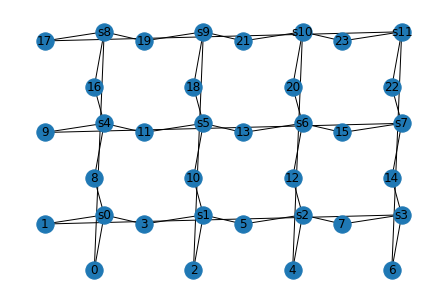

In [10]:
r1 = 4 # horizontal dimension of toric code
r2 = 3 # vertical dimension of toric code
N = 2*r1*r2 # number of data qubits
Ns = r1*r2 # number of stabilizers

Sz = np.zeros((r1*r2,2*r1*r2),dtype=int)
pos = dict()
for i_y in range(r2):
    for i_x in range(r1):
        Sz[i_y*r1 + i_x, 2*(i_y*r1 + i_x)] = 1
        Sz[i_y*r1 + i_x, 2*(i_y*r1 + i_x)+1] = 1
        Sz[i_y*r1 + i_x, 2*(i_y*r1+(i_x+1)%r1 )+1] = 1
        Sz[i_y*r1 + i_x, 2*(((i_y+1)%r2)*r1+i_x)] = 1
        pos["s%d" % (i_y*r1 + i_x)] = (i_x+0.6,i_y+0.6)
        pos[2*(i_y*r1 + i_x)] = (i_x+0.5,i_y)
        pos[2*(i_y*r1 + i_x)+1] = (i_x,i_y+0.5)
        pos[2*(i_y*r1+(i_x-1)%r1 )] = (i_x-0.5,i_y)
        pos[ 2*(((i_y-1)%r2)*r1+i_x)+1] = (i_x,i_y-0.5)

B_orig = nx.Graph()
B_orig.add_nodes_from(np.arange(N))#, bipartite=0)
s_nodes = ["s%d" % s for s in np.arange(Ns)]
B_orig.add_nodes_from(s_nodes)#, bipartite=1)
for row in range(np.size(Sz,0)):
    qs = np.argwhere(Sz[row,:]>0)[:,0]
    B_orig.add_edges_from([("s%d" % row, q) for q in qs])

# print(B_orig.nodes())
# pos = graphviz_layout(B_orig, prog='dot')

nx.draw(B_orig, pos,  with_labels=True)#, node_color = color_list)
plt.show()

logicals_z_latt = np.zeros((2,2*r1*r2))
logicals_z_latt[1,0:2*r1:2] = np.ones(r1) 
logicals_z_latt[0,1:2*r1*r2:2*r1] = np.ones(r2) 

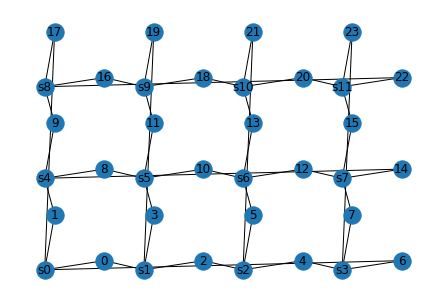

In [11]:
Sx = np.zeros((r1*r2,2*r1*r2),dtype=int)
pos = dict()
for i_y in range(r2):
    for i_x in range(r1):
        Sx[i_y*r1 + i_x, 2*(i_y*r1 + i_x)] = 1
        Sx[i_y*r1 + i_x, 2*(i_y*r1 + i_x)+1] = 1
        Sx[i_y*r1 + i_x, 2*(i_y*r1+(i_x-1)%r1 )] = 1
        Sx[i_y*r1 + i_x, 2*(((i_y-1)%r2)*r1+i_x)+1] = 1
        pos["s%d" % (i_y*r1 + i_x)] = (i_x-0.1,i_y-0.1)
        pos[2*(i_y*r1 + i_x)] = (i_x+0.5,i_y)
        pos[2*(i_y*r1 + i_x)+1] = (i_x,i_y+0.5)
        pos[2*(i_y*r1+(i_x-1)%r1 )] = (i_x-0.5,i_y)
        pos[ 2*(((i_y-1)%r2)*r1+i_x)+1] = (i_x,i_y-0.5)

B_orig = nx.Graph()
B_orig.add_nodes_from(np.arange(N))#, bipartite=0)
s_nodes = ["s%d" % s for s in np.arange(Ns)]
B_orig.add_nodes_from(s_nodes)#, bipartite=1)
for row in range(np.size(Sx,0)):
    qs = np.argwhere(Sx[row,:]>0)[:,0]
    B_orig.add_edges_from([("s%d" % row, q) for q in qs])

# print(B_orig.nodes())

# pos = graphviz_layout(B_orig, prog='dot')

nx.draw(B_orig, pos,  with_labels=True)#, node_color = color_list)
plt.show()

logicals_x_latt = np.zeros((2,2*r1*r2))
logicals_x_latt[0,1:2*r1:2] = np.ones(r1) 
logicals_x_latt[1,0:2*r1*r2:2*r1] = np.ones(r2) 

In [12]:
print(logicals_x_latt@logicals_z_latt.T)

[[1. 0.]
 [0. 1.]]


## sanity check
Calculate logical operator from stabilizer matrices

In [13]:
from PLmatrix_CSS import *
H_X = np.copy(Sx)
H_Z = np.copy(Sz)
n = 2*r1*r2
k = 2

print(H_X.shape, H_Z.shape)
n_row = np.size(H_X,axis=0)
H_Xb = []
H_Zb = []
for i_r in range(n_row):
    H_Xb.append(np.sum(H_X[i_r,:]* 2**np.arange(n-1,-1,-1)))
    H_Zb.append(np.sum(H_Z[i_r,:]* 2**np.arange(n-1,-1,-1)))

H_Xbc = H_Xb.copy()
H_Zbc = H_Zb.copy()
H_Xb1, RoX = gf2_rank(H_Xbc)
H_Zb1, RoZ = gf2_rank(H_Zbc)

print(len(H_Xb1))
r = len(H_Xb1)

H_X_new = Hb_to_H(n,r,H_Xb1)
H_Z_new = Hb_to_H(n,r,H_Zb1)
H_XZ = np.zeros((2*r,2*n), dtype = int)
H_XZ[0:r, 0:n] = H_X_new
H_XZ[r:2*r, n:] = H_Z_new

Sx_mat = H_XZ[:, 0:n]
Sx_mat = Sx_mat[~np.all(Sx_mat == 0, axis=1)]
Sz_mat = H_XZ[:, n:2*n]
Sz_mat = Sz_mat[~np.all(Sz_mat == 0, axis=1)]
Nq_l = np.size(Sx_mat,1) # number of data qubits per layer
Ns_l = np.size(Sx_mat,0) # number of stabilizers per layer
logicals_X = logical_from_Hparity(H_XZ, Nq_l, k, Ns_l)[0]
logicals_Z = logical_from_Hparity(H_XZ, Nq_l, k, Ns_l)[1]
logical_tX = logicals_X[:,0:Nq_l]
logical_tZ = logicals_Z[:,Nq_l:2*Nq_l]

print((logical_tX@logical_tZ.T)%2)

(12, 24) (12, 24)
11
[[1 0]
 [0 1]]


## comparison
Commutation relation of lattice logical ops and output of the above code

In [17]:
print((logicals_z_latt@logical_tX.T)%2)
print((logicals_x_latt@logical_tZ.T)%2)

[[1. 1.]
 [0. 0.]]
[[1. 1.]
 [0. 0.]]
